# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Загрузка данных

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
glass_identification = fetch_ucirepo(id=42) 
  
# data (as pandas dataframes) 
X = glass_identification.data.features 
y = glass_identification.data.targets 
  
# metadata 
print(glass_identification.metadata) 
  
# variable information 
print(glass_identification.variables) 

{'uci_id': 42, 'name': 'Glass Identification', 'repository_url': 'https://archive.ics.uci.edu/dataset/42/glass+identification', 'data_url': 'https://archive.ics.uci.edu/static/public/42/data.csv', 'abstract': 'From USA Forensic Science Service; 6 types of glass; defined in terms of their oxide content (i.e. Na, Fe, K, etc)', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 214, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Type_of_glass'], 'index_col': ['Id_number'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1987, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5WW2P', 'creators': ['B. German'], 'intro_paper': None, 'additional_info': {'summary': 'Vina conducted a comparison test of her rule-based system, BEAGLE, the nearest-neighbor algorithm, and discriminant analysis.  BEAGLE is a product available through VRS Consulting, In

1. Id number: 1 to 214
2. RI: refractive index
3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
4. Mg: Magnesium
5. Al: Aluminum
6. Si: Silicon
7. K: Potassium
8. Ca: Calcium
9. Ba: Barium
10. Fe: Iron
11. Type of glass: (class attribute)
     -- 1 building_windows_float_processed
     -- 2 building_windows_non_float_processed
     -- 3 vehicle_windows_float_processed
     -- 4 vehicle_windows_non_float_processed (none in this database)
     -- 5 containers
     -- 6 tableware
     -- 7 headlamps

# Анализ данных

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
dtypes: float64(9)
memory usage: 15.2 KB


In [4]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Type_of_glass  214 non-null    int64
dtypes: int64(1)
memory usage: 1.8 KB


Фичи и таргет пропусков не имеют

In [5]:
y.value_counts(normalize=True)

Type_of_glass
2                0.355140
1                0.327103
7                0.135514
3                0.079439
5                0.060748
6                0.042056
Name: proportion, dtype: float64

<Axes: xlabel='Type_of_glass', ylabel='count'>

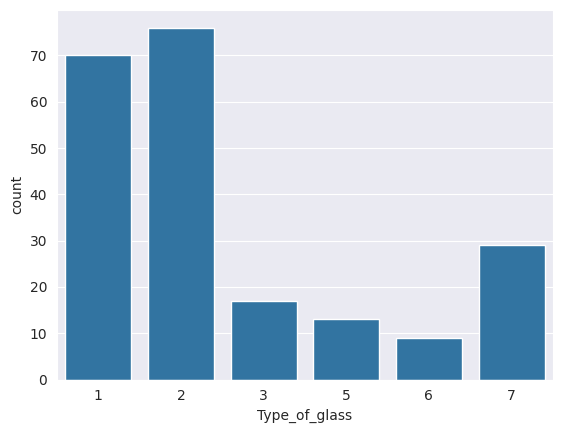

In [6]:
sns.countplot(data=y, x = "Type_of_glass")

По цифрам и по графику видим, что классы таргета не сбалансированы.
Есть 3 минорных класса: 3, 5, 6. 
Образцы 4 класса в выборке отсутствуют вовсе.

Построим гистограммы распределения

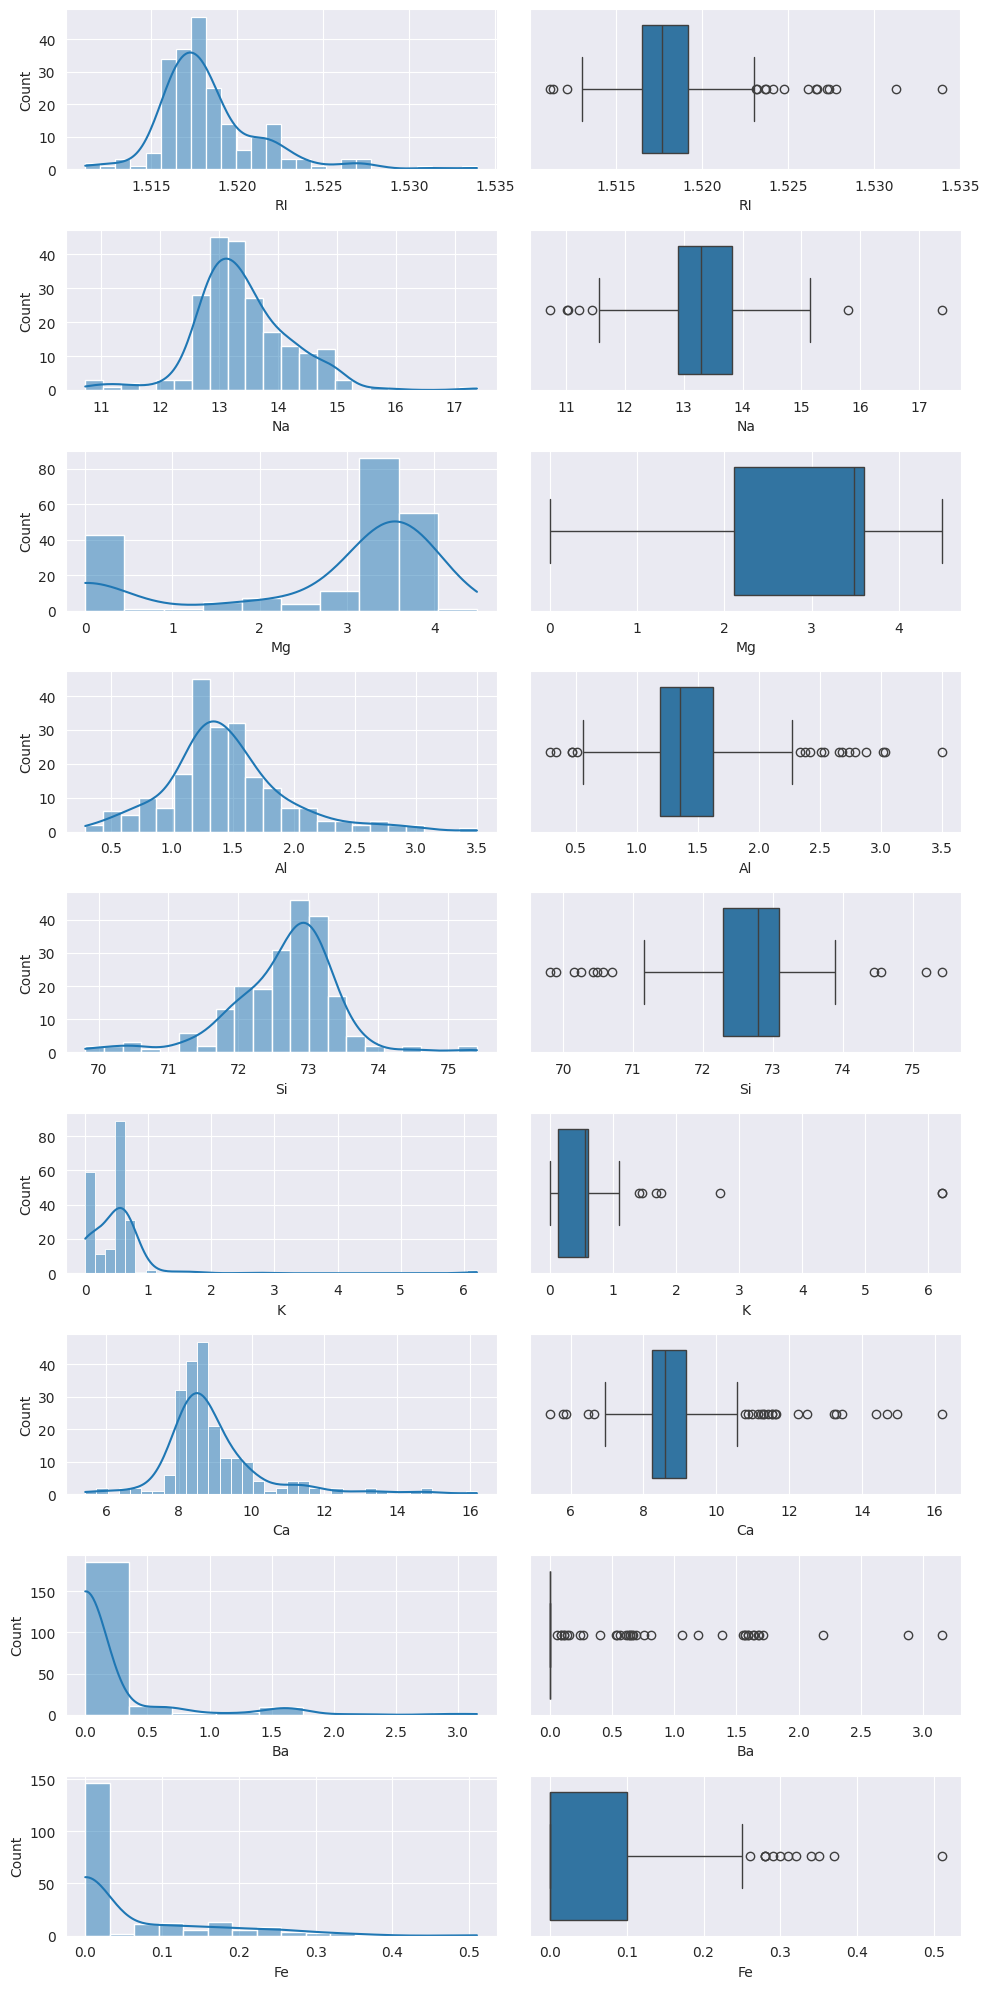

In [7]:
n_rows = len(X.columns)
n_cols = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 20))

for ax, feature in enumerate(X.columns):
    sns.histplot(data=X, x=feature, kde=True, ax=axes[ax, 0])
    sns.boxplot(data=X, x=feature, ax=axes[ax, 1])
    # axs[row][col].set_title(feature)
    
plt.tight_layout()
plt.show()

Распределение большинства признаков далеко от нормального, есть выбросы.
Учтем это при масштабировании.

Построим корреляционную матрицу

<Axes: >

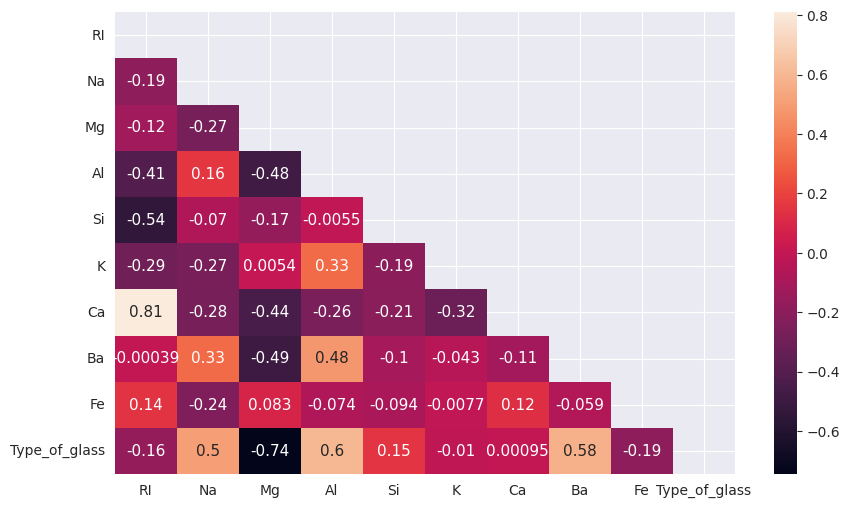

In [8]:
df = pd.concat([X, y], axis=1)

corr_matrix = df.corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, mask=mask, annot=True, annot_kws={"fontsize":11})

Наблюдается корреляция содержания оксида кальция (Ca) и индекса преломления (RI)

# Масштабирование

Как было замечено ранее, фичи имеют выбросы, поэтому применим к данным степенное преобразование

In [9]:
scaler = PowerTransformer(method="yeo-johnson", standardize=True)

# scaler = QuantileTransformer(output_distribution="normal", random_state=42)
# scaler = RobustScaler(with_centering=True, with_scaling=True)

X_ = scaler.fit_transform(X)
y_ = y.to_numpy().ravel()

# LogisticRegression

Для классификации будем использовать логистическую регрессию

Разобъем наш датасет на тренировочную и тестовую части. 
Передача аргумента stratify=y обеспечит нам пропорциональное представительство
разных классов как в тренировочной, так и в тестовой выборках.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=42, stratify=y)

## default

Сначала прогоним наши данные "как есть" через логистическую регрессию с параметрами по умолчанию
и сравним метрики на тренировочной и тестовой частях

In [11]:
model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)

y_train_predicted = model.predict(X_train)
print("TRAIN data\n",
      classification_report(y_true=y_train, y_pred=y_train_predicted, zero_division=0))

y_test_predicted = model.predict(X_test)
print("TEST data\n",
      classification_report(y_true=y_test, y_pred=y_test_predicted, zero_division=0))

TRAIN data
               precision    recall  f1-score   support

           1       0.64      0.76      0.69        49
           2       0.66      0.72      0.68        53
           3       0.00      0.00      0.00        12
           5       0.86      0.67      0.75         9
           6       0.86      1.00      0.92         6
           7       0.95      0.90      0.92        20

    accuracy                           0.70       149
   macro avg       0.66      0.67      0.66       149
weighted avg       0.66      0.70      0.68       149

TEST data
               precision    recall  f1-score   support

           1       0.64      0.76      0.70        21
           2       0.77      0.74      0.76        23
           3       0.00      0.00      0.00         5
           5       1.00      1.00      1.00         4
           6       0.75      1.00      0.86         3
           7       1.00      1.00      1.00         9

    accuracy                           0.75        65


Видим, что наша модель имеет неплохие средние показатели (macro avg)
Причем, на тесте даже лучше, чем на обучающей.
Вместе с тем, мы видим, что модель "потеряла" один из наших минорных классов - 3.

Попробуем это поправить вручную задав веса для каждого класса.
Для минорного - больше, для мажорного меньше.
Веса выберем обратно пропорционально представительству, 
т.е. чем больше в выборке образцов класса, тем меньше поставим его вес.

## class weight

In [12]:
weights = {
    1:0.25,
    2:0.25,
    3:1,
    5:1,
    6:1,
    7:0.5
}

model = LogisticRegression(random_state=42, class_weight=weights)
model.fit(X_train, y_train)

y_train_predicted = model.predict(X_train)
print("TRAIN data\n",
      classification_report(y_true=y_train, y_pred=y_train_predicted, zero_division=0))

y_test_predicted = model.predict(X_test)
print("TEST data\n",
      classification_report(y_true=y_test, y_pred=y_test_predicted, zero_division=0))

TRAIN data
               precision    recall  f1-score   support

           1       0.63      0.59      0.61        49
           2       0.63      0.45      0.53        53
           3       0.19      0.42      0.26        12
           5       0.64      1.00      0.78         9
           6       0.86      1.00      0.92         6
           7       0.94      0.85      0.89        20

    accuracy                           0.60       149
   macro avg       0.65      0.72      0.67       149
weighted avg       0.65      0.60      0.61       149

TEST data
               precision    recall  f1-score   support

           1       0.68      0.62      0.65        21
           2       0.69      0.39      0.50        23
           3       0.14      0.40      0.21         5
           5       0.80      1.00      0.89         4
           6       0.75      1.00      0.86         3
           7       0.90      1.00      0.95         9

    accuracy                           0.62        65


Средние значения метрик ухудшились, но зато наша модель научилась находить 3 класс,
хотя и с весьма слабыми показателями precision/recall

Попробуем применить некоторые методы устранения дисбаланса классов

# Устранение дисбаланса классов

In [13]:
# снова создаем модель - логистическую регрессию
model = LogisticRegression(random_state=42)

## Oversampling

### RandomOverSampler

Object to over-sample the minority class(es) by picking samples 
at random with replacement. The bootstrap can be generated 
in a smoothed manner.



Везде далее мы будем действовать по одной и той же схеме:
- применяем к обучающим данным ресемплер
- смотрим на графике как изменилось распределение 
- обучаем на полученных данных модель
- оцениваем результаты

In [14]:
from imblearn.over_sampling import RandomOverSampler
resampler = RandomOverSampler(random_state=42)

X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)

In [15]:
def plot_resampled_target(before, after):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    axes[0].set_title("Before resampling")
    sns.countplot(data=pd.DataFrame(before, columns=["Type_of_glass"]), x="Type_of_glass", ax=axes[0])
    axes[1].set_title("After resampling")
    sns.countplot(data=pd.DataFrame(after, columns=["Type_of_glass"]), x="Type_of_glass", ax=axes[1])

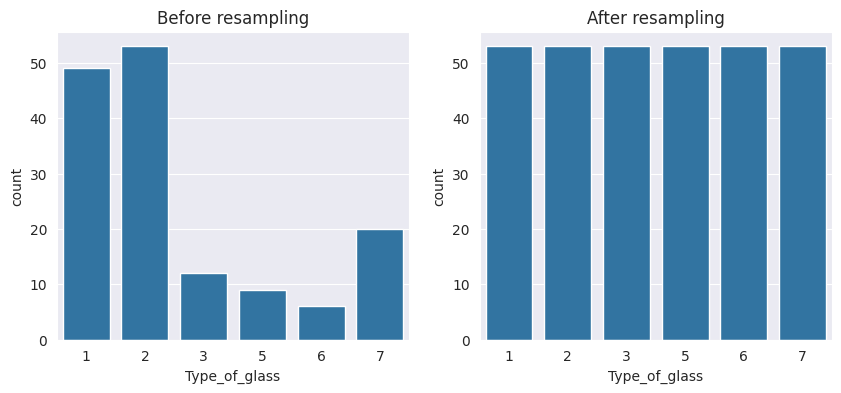

In [16]:
plot_resampled_target(before=y_train, after=y_train_resampled)

Видим, что все классы, которые были меньше чем самый многочисленный 
класс 2, увеличены до его уровня

In [17]:
model.fit(X_train_resampled, y_train_resampled)

y_train_resampled_predicted = model.predict(X_train_resampled)
print("RESAMPLED TRAIN data\n", 
      classification_report(y_true=y_train_resampled, y_pred=y_train_resampled_predicted, zero_division=0))

y_test_predicted = model.predict(X_test)
print("TEST data\n",
      classification_report(y_true=y_test, y_pred=y_test_predicted, zero_division=0))

RESAMPLED TRAIN data
               precision    recall  f1-score   support

           1       0.62      0.70      0.65        53
           2       0.53      0.36      0.43        53
           3       0.54      0.60      0.57        53
           5       0.93      1.00      0.96        53
           6       0.98      1.00      0.99        53
           7       0.98      0.96      0.97        53

    accuracy                           0.77       318
   macro avg       0.76      0.77      0.76       318
weighted avg       0.76      0.77      0.76       318

TEST data
               precision    recall  f1-score   support

           1       0.62      0.62      0.62        21
           2       0.64      0.30      0.41        23
           3       0.00      0.00      0.00         5
           5       0.67      1.00      0.80         4
           6       0.75      1.00      0.86         3
           7       0.82      1.00      0.90         9

    accuracy                           0.55 

Весьма неплохо на обучающей выборке и хуже, чем без ресемплинга на тестовой
И модель опять потеряла класс 3

## Undersampling

### ClusterCentroids

Method that under samples the majority class by replacing a cluster 
of majority samples by the cluster centroid of a KMeans algorithm. 
This algorithm keeps N majority samples by fitting the KMeans algorithm 
with N cluster to the majority class and using the coordinates of the N 
cluster centroids as the new majority samples.

Метод, который выполняет выборку большинства классов путем замены 
кластера большинства выборок центроидом кластера алгоритма KMeans. 
Этот алгоритм сохраняет N выборок большинства, подгоняя алгоритм KMeans 
с кластером N к классу большинства и используя координаты центроидов N 
кластеров в качестве новых выборок большинства.

Ни хрена не понятно, но очень интересно )

/home/serhii/PycharmProjects/hillel/ML/hillel_ml_learning_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/serhii/PycharmProjects/hillel/ML/hillel_ml_learning_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/serhii/PycharmProjects/hillel/ML/hillel_ml_learning_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/

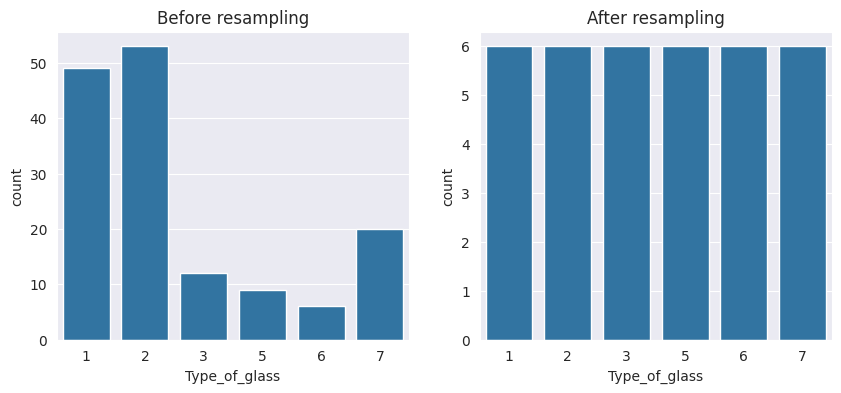

In [18]:
from imblearn.under_sampling import ClusterCentroids
resampler = ClusterCentroids(sampling_strategy="auto", random_state=42)

X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)
plot_resampled_target(before=y_train, after=y_train_resampled)

Видим изменившийся масштаб на графике справа (6) по сравнению с графиком слева (50)
Ресемплер обрезал все классы по самому малочисленному
 

In [19]:
model.fit(X_train_resampled, y_train_resampled)

y_train_resampled_predicted = model.predict(X_train_resampled)
print("RESAMPLED TRAIN data\n", 
      classification_report(y_true=y_train_resampled, y_pred=y_train_resampled_predicted, zero_division=0))

y_test_predicted = model.predict(X_test)
print("TEST data\n",
      classification_report(y_true=y_test, y_pred=y_test_predicted, zero_division=0))

RESAMPLED TRAIN data
               precision    recall  f1-score   support

           1       0.56      0.83      0.67         6
           2       1.00      0.67      0.80         6
           3       0.50      0.50      0.50         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      0.83      0.91         6

    accuracy                           0.81        36
   macro avg       0.84      0.81      0.81        36
weighted avg       0.84      0.81      0.81        36

TEST data
               precision    recall  f1-score   support

           1       0.56      0.67      0.61        21
           2       0.80      0.17      0.29        23
           3       0.07      0.20      0.11         5
           5       0.67      1.00      0.80         4
           6       0.75      1.00      0.86         3
           7       0.82      1.00      0.90         9

    accuracy                           0.54 

Снова отличные результаты на обучающей выборке и провал на тестовой

## Combination of over- and under-sampling methods

### SMOTEENN

Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours.

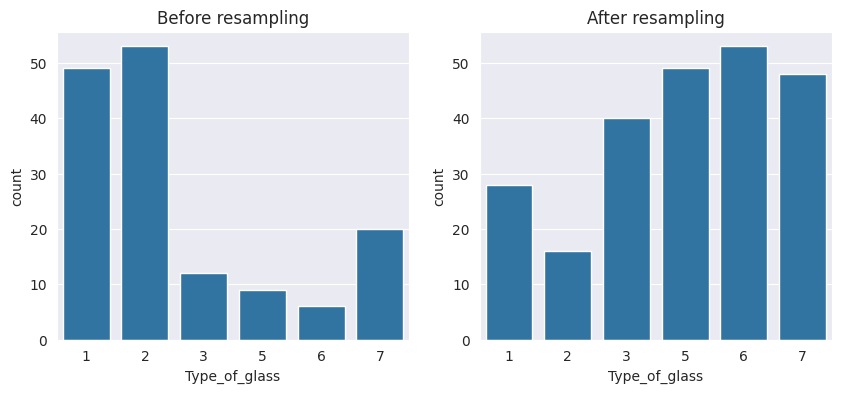

In [20]:
from imblearn.combine import SMOTEENN
resampler = SMOTEENN(random_state=42)

X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)
plot_resampled_target(before=y_train, after=y_train_resampled)

В данном случае ресемплер уменьшил мажорные классы 1 и 2 и увеличил минорные 3, 5, 6, 7

In [21]:
model.fit(X_train_resampled, y_train_resampled)

y_train_resampled_predicted = model.predict(X_train_resampled)
print("RESAMPLED TRAIN data\n", 
      classification_report(y_true=y_train_resampled, y_pred=y_train_resampled_predicted, zero_division=0))

y_test_predicted = model.predict(X_test)
print("TEST data\n",
      classification_report(y_true=y_test, y_pred=y_test_predicted, zero_division=0))

RESAMPLED TRAIN data
               precision    recall  f1-score   support

           1       0.93      0.93      0.93        28
           2       1.00      0.75      0.86        16
           3       0.89      0.97      0.93        40
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        53
           7       1.00      1.00      1.00        48

    accuracy                           0.97       234
   macro avg       0.97      0.94      0.95       234
weighted avg       0.97      0.97      0.97       234

TEST data
               precision    recall  f1-score   support

           1       0.67      0.38      0.48        21
           2       0.62      0.35      0.44        23
           3       0.09      0.40      0.15         5
           5       0.40      0.50      0.44         4
           6       0.60      1.00      0.75         3
           7       1.00      0.89      0.94         9

    accuracy                           0.48 

И снова модель очень точна на обучающих данных 0.97 и даже не дотянула до 0.5 на тестовой выборке

### SMOTETomek

Combine over- and under-sampling using SMOTE and Tomek links.

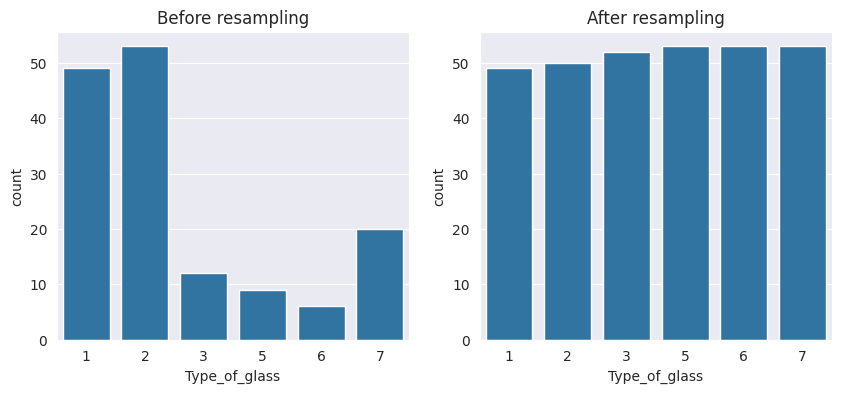

In [22]:
from imblearn.combine import SMOTETomek
resampler = SMOTETomek(random_state=42)

X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)
plot_resampled_target(before=y_train, after=y_train_resampled)

In [23]:
model.fit(X_train_resampled, y_train_resampled)

y_train_resampled_predicted = model.predict(X_train_resampled)
print("RESAMPLED TRAIN data\n", 
      classification_report(y_true=y_train_resampled, y_pred=y_train_resampled_predicted, zero_division=0))

y_test_predicted = model.predict(X_test)
print("TEST data\n",
      classification_report(y_true=y_test, y_pred=y_test_predicted, zero_division=0))

RESAMPLED TRAIN data
               precision    recall  f1-score   support

           1       0.68      0.73      0.71        49
           2       0.57      0.32      0.41        50
           3       0.58      0.73      0.64        52
           5       0.90      1.00      0.95        53
           6       0.98      1.00      0.99        53
           7       0.98      0.92      0.95        53

    accuracy                           0.79       310
   macro avg       0.78      0.78      0.77       310
weighted avg       0.79      0.79      0.78       310

TEST data
               precision    recall  f1-score   support

           1       0.67      0.67      0.67        21
           2       0.67      0.35      0.46        23
           3       0.08      0.20      0.12         5
           5       0.80      1.00      0.89         4
           6       0.75      1.00      0.86         3
           7       0.82      1.00      0.90         9

    accuracy                           0.60 

В данном случае результаты сравнимы с тем случаем, где мы вручную задавали 
веса классов. Но опять же видим, что класс 3 тянет все показатели вниз.

Если при масштабировании земенить PowerTransformer на RobustScaler, то 
метрики на тестовых выборках незначительно улучшатся при использовании тех
ресемплеров, которые используют оверсемплинг (RandomOverSampler, SMOTEENN, SMOTETomek)

# Обучение на одном классе

Попробуем научить нашу модель находить один конкретный класс - 
класс 3 с которым до сих пор были проблемы во всех предыдущих случаях

In [24]:
# Создаем новый таргет, где образцы 3 класса будут обозначаться 1, а все остальные классы 0 

c3_dict = {1: 0, 
           2: 0,
           3: 1,
           4: 0,
           5: 0,
           6: 0,
           7: 0
           }

y_c3 = y.replace({"Type_of_glass": c3_dict})
y_c3_ = y_c3.to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(X_, y_c3_, test_size=0.3, random_state=42, stratify=y)

In [31]:
model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)

y_train_predicted = model.predict(X_train)
print("TRAIN data\n",
      classification_report(y_true=y_train, y_pred=y_train_predicted, zero_division=0))

y_test_predicted = model.predict(X_test)
print("TEST data\n",
      classification_report(y_true=y_test, y_pred=y_test_predicted, zero_division=0))

TRAIN data
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       137
           1       0.00      0.00      0.00        12

    accuracy                           0.92       149
   macro avg       0.46      0.50      0.48       149
weighted avg       0.85      0.92      0.88       149

TEST data
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        60
           1       0.00      0.00      0.00         5

    accuracy                           0.92        65
   macro avg       0.46      0.50      0.48        65
weighted avg       0.85      0.92      0.89        65


Видим, что наша модель совершенно не способна находить миноритарнй класс.
И на обучающей и на тестовой выборке результат по нулям

Снова попробуем устранить дисбаланс известными нам методами

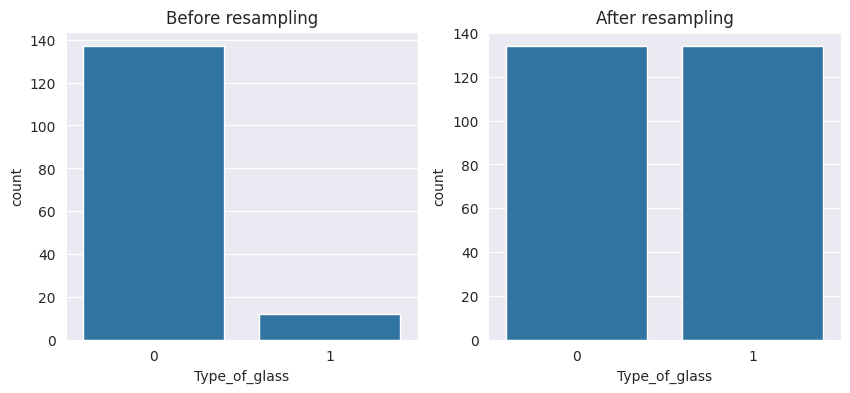

In [32]:
resampler = SMOTETomek(random_state=42)

X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)
plot_resampled_target(before=y_train, after=y_train_resampled)

In [33]:
model.fit(X_train_resampled, y_train_resampled)

y_train_resampled_predicted = model.predict(X_train_resampled)
print("RESAMPLED TRAIN data\n", 
      classification_report(y_true=y_train_resampled, y_pred=y_train_resampled_predicted, zero_division=0))

y_test_predicted = model.predict(X_test)
print("TEST data\n",
      classification_report(y_true=y_test, y_pred=y_test_predicted, zero_division=0))

RESAMPLED TRAIN data
               precision    recall  f1-score   support

           0       0.83      0.54      0.65       134
           1       0.66      0.89      0.76       134

    accuracy                           0.71       268
   macro avg       0.74      0.71      0.70       268
weighted avg       0.74      0.71      0.70       268

TEST data
               precision    recall  f1-score   support

           0       0.97      0.57      0.72        60
           1       0.13      0.80      0.23         5

    accuracy                           0.58        65
   macro avg       0.55      0.68      0.47        65
weighted avg       0.91      0.58      0.68        65


Видим, что модель научилась находить объекты 3 класса.
Нашла их 80% в тестовой выборке, но при этом, точность всего 13%
Если я правильно понимаю, модель много промахивается, 
ошибочно относя объекты других классов к 3 классу

Что с этим делать я пока не понимаю. Возможно стоит попробовать другую модель.
Хотя в описании датасета заявлено, что *accuracy* при использовании
логистической регрессии лежит в диапазоне от 0.52 до 0.78,
а *precision* в диапазоне от 0.36 до 0.72   